In [2]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar a base de dados
dados = pd.read_excel('german_credit_risk.xlsx')
dados.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
# Remover coluna desnecessária
dados = dados.drop(columns=['Unnamed: 0'])

# Preencher valores nulos
dados['Saving accounts'].fillna('unknown', inplace=True)
dados['Checking account'].fillna('unknown', inplace=True)

# Criar variável auxiliar: crédito por mês
dados['credito_mensal'] = dados['Credit amount'] / dados['Duration']

# Verificar tipos de dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   1000 non-null   object 
 5   Checking account  1000 non-null   object 
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
 9   Risk              1000 non-null   object 
 10  credito_mensal    1000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 86.1+ KB


/tmp/ipython-input-3369856676.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['Saving accounts'].fillna('unknown', inplace=True)
/tmp/ipython-input-3369856676.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [4]:
# Separar variáveis explicativas e alvo
X = dados.drop('Risk', axis=1)
y = dados['Risk'].map({'good': 0, 'bad': 1})  # 0 = bom pagador, 1 = mau pagador

# Separar conjuntos (60% treino, 20% validação, 20% teste)
X_treino, X_temp, y_treino, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_teste, y_valid, y_teste = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamanho treino: {len(X_treino)} | validação: {len(X_valid)} | teste: {len(X_teste)}")

Tamanho treino: 600 | validação: 200 | teste: 200


In [5]:
# Separar variáveis numéricas e categóricas
num_cols = ['Age', 'Job', 'Credit amount', 'Duration', 'credito_mensal']
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Pré-processador
transformador = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [7]:
# Modelo 1 - Regressão Logística
modelo_lr = Pipeline([
    ('pre', transformador),
    ('clf', LogisticRegression(max_iter=1000))
])

# Treinar
modelo_lr.fit(X_treino, y_treino)

# Avaliar
prev_lr = modelo_lr.predict(X_valid)
print("Acurácia - Regressão Logística:", accuracy_score(y_valid, prev_lr))
print(classification_report(y_valid, prev_lr))

# Modelo 2 - Random Forest
modelo_rf = Pipeline([
    ('pre', transformador),
    ('clf', RandomForestClassifier(random_state=42))
])

# Treinar com ajuste simples de parâmetros
parametros = {'clf__n_estimators': [50, 100],
              'clf__max_depth': [4, 8, None]}

busca = GridSearchCV(modelo_rf, parametros, cv=3, scoring='accuracy')
busca.fit(X_treino, y_treino)

print("Melhores parâmetros:", busca.best_params_)

# Avaliar
prev_rf = busca.predict(X_valid)
print("Acurácia - Random Forest:", accuracy_score(y_valid, prev_rf))
print(classification_report(y_valid, prev_rf))

Acurácia - Regressão Logística: 0.73
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       137
           1       0.63      0.35      0.45        63

    accuracy                           0.73       200
   macro avg       0.69      0.63      0.64       200
weighted avg       0.71      0.73      0.70       200

Melhores parâmetros: {'clf__max_depth': 8, 'clf__n_estimators': 50}
Acurácia - Random Forest: 0.725
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       137
           1       0.65      0.27      0.38        63

    accuracy                           0.72       200
   macro avg       0.69      0.60      0.60       200
weighted avg       0.71      0.72      0.68       200



=== Avaliação Final ===
Acurácia no teste: 0.765
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       145
           1       0.65      0.31      0.42        55

    accuracy                           0.77       200
   macro avg       0.72      0.62      0.64       200
weighted avg       0.75      0.77      0.73       200



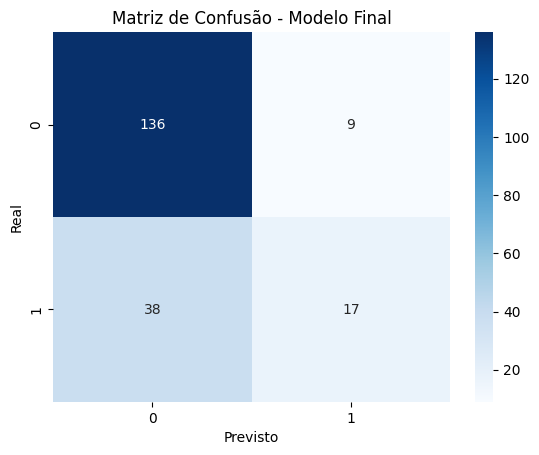

In [8]:
# Escolher melhor modelo
modelo_final = busca.best_estimator_

# Teste final
prev_teste = modelo_final.predict(X_teste)

print("=== Avaliação Final ===")
print("Acurácia no teste:", accuracy_score(y_teste, prev_teste))
print(classification_report(y_teste, prev_teste))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_teste, prev_teste), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Modelo Final")
plt.show()

**Conclusão**

O modelo de Regressão Logística apresentou desempenho ligeiramente superior ao Random Forest, especialmente na identificação de clientes de alto risco (classe 1).

Apesar das acurácias semelhantes, a Regressão Logística demonstrou maior recall para a classe de risco, reduzindo falsos negativos — o que é crucial para minimizar perdas financeiras.

Assim, a Regressão Logística se mostra mais apropriada para o problema.

Principais variáveis preditoras: Credit amount, Checking account, Saving accounts e Duration.